New Hypothesis:
YOLOv8-Seg should perform better on moving objects, while CLIPSeg might perform better on still objects due to its ability to leverage textual descriptions.



In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import torch

# Paths
VIDEO_FOLDER = "C:\\Users\\Lenovo\\Desktop\\comp-vison-chap1\\TP2\\data\\baseline\\pedestrians"
INPUT_FOLDER = os.path.join(VIDEO_FOLDER, "input")
RESULTS_FOLDER_MOVING = os.path.join(VIDEO_FOLDER, "results_moving")
RESULTS_FOLDER_STILL = os.path.join(VIDEO_FOLDER, "results_still")
GROUNDTRUTH_FOLDER = os.path.join(VIDEO_FOLDER, "groundtruth")
TEMPORAL_ROI_FILE = os.path.join(VIDEO_FOLDER, "temporalROI.txt")

# Read temporal ROI (frame range to evaluate)
with open(TEMPORAL_ROI_FILE, "r") as f:
    start_frame, end_frame = map(int, f.readline().split())

# List input images
input_images = sorted([img for img in os.listdir(INPUT_FOLDER) if img.endswith(".jpg")])[start_frame-1:end_frame]

# Create results folders
os.makedirs(RESULTS_FOLDER_MOVING, exist_ok=True)
os.makedirs(RESULTS_FOLDER_STILL, exist_ok=True)


In [4]:
# Load YOLOv8 segmentation model
yolo_model = YOLO("yolov8n-seg.pt")  # Use "yolov8m-seg.pt" for better accuracy

def apply_yolo_segmentation(image_path):
    image = cv2.imread(image_path)
    results = yolo_model(image)[0]  # Get YOLO results

    # Create empty mask
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    # Ensure detections exist before accessing `masks`
    if results.masks is not None:
        for mask_data in results.masks.xy:
            cv2.fillPoly(mask, [np.array(mask_data, dtype=np.int32)], 255)  # Fill segmentation mask

    return mask


In [5]:
# Load CLIPSeg Model
device = "cuda" if torch.cuda.is_available() else "cpu"
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

def apply_clipseg(image_path, text_prompt="still and moving human"):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512), Image.LANCZOS)  # Scale up small objects

    # Process image and text
    inputs = processor(text=[text_prompt], images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = clipseg_model(**inputs)

    mask = outputs.logits.squeeze().cpu().numpy()
    mask = (mask > 0.3).astype(np.uint8) * 255  # Adjust threshold

    return mask


In [13]:
for i, image_name in enumerate(input_images):
    image_path = os.path.join(INPUT_FOLDER, image_name)
    
    save_path_yolo_moving = os.path.join(RESULTS_FOLDER_MOVING, f"bin{image_name[2:]}")
    save_path_clipseg_moving = os.path.join(RESULTS_FOLDER_MOVING, f"clip_{image_name[2:]}")
    
    save_path_yolo_still = os.path.join(RESULTS_FOLDER_STILL, f"bin{image_name[2:]}")
    save_path_clipseg_still = os.path.join(RESULTS_FOLDER_STILL, f"clip_{image_name[2:]}")

    # Apply YOLOv8-Seg for moving and still objects
    yolo_mask = apply_yolo_segmentation(image_path)
    cv2.imwrite(save_path_yolo_moving, yolo_mask)
    cv2.imwrite(save_path_yolo_still, yolo_mask)

    # Apply CLIPSeg for moving and still objects
    clipseg_mask_moving = apply_clipseg(image_path, "moving pedestrians")
    clipseg_mask_still = apply_clipseg(image_path, "still pedestrians")

    cv2.imwrite(save_path_clipseg_moving, clipseg_mask_moving)
    cv2.imwrite(save_path_clipseg_still, clipseg_mask_still)

    if i % 50 == 0:
        print(f"Processed {i+1}/{len(input_images)} frames...")



0: 448x640 1 bicycle, 1 car, 1 fire hydrant, 74.4ms
Speed: 333.2ms preprocess, 74.4ms inference, 5.8ms postprocess per image at shape (1, 3, 448, 640)
Processed 1/800 frames...

0: 448x640 1 bicycle, 1 car, 1 fire hydrant, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 1 car, 1 fire hydrant, 15.2ms
Speed: 2.9ms preprocess, 15.2ms inference, 4.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 1 car, 1 fire hydrant, 14.9ms
Speed: 3.0ms preprocess, 14.9ms inference, 3.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 1 car, 1 fire hydrant, 14.7ms
Speed: 2.9ms preprocess, 14.7ms inference, 4.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bicycle, 1 car, 1 fire hydrant, 14.7ms
Speed: 1.9ms preprocess, 14.7ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 1 car, 1 

In [14]:
# Function to calculate metrics
def calculate_metrics(pred_mask, gt_mask):
    pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    pred_mask = (pred_mask > 127).astype(np.uint8)
    gt_mask = (gt_mask > 127).astype(np.uint8)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    true_positive = intersection
    false_positive = pred_mask.sum() - true_positive
    false_negative = gt_mask.sum() - true_positive

    iou = intersection / union if union > 0 else 0
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return iou, precision, recall, f1_score


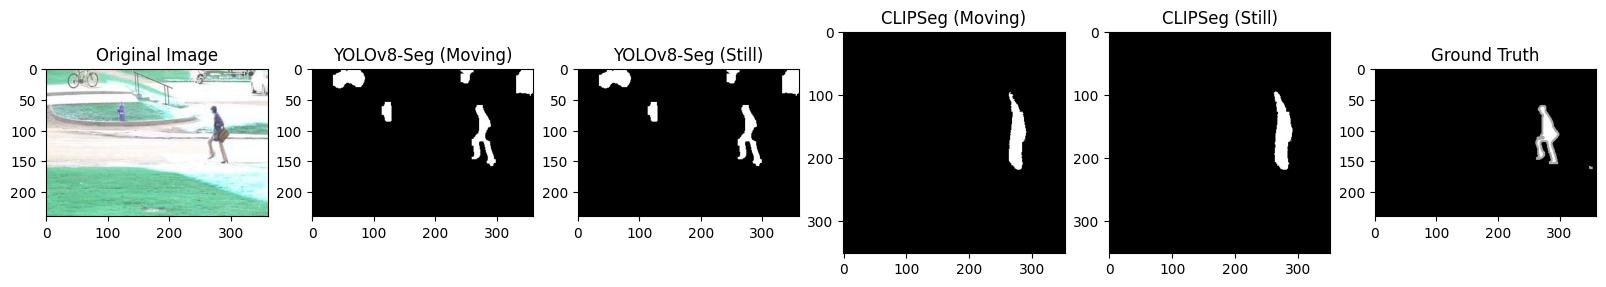

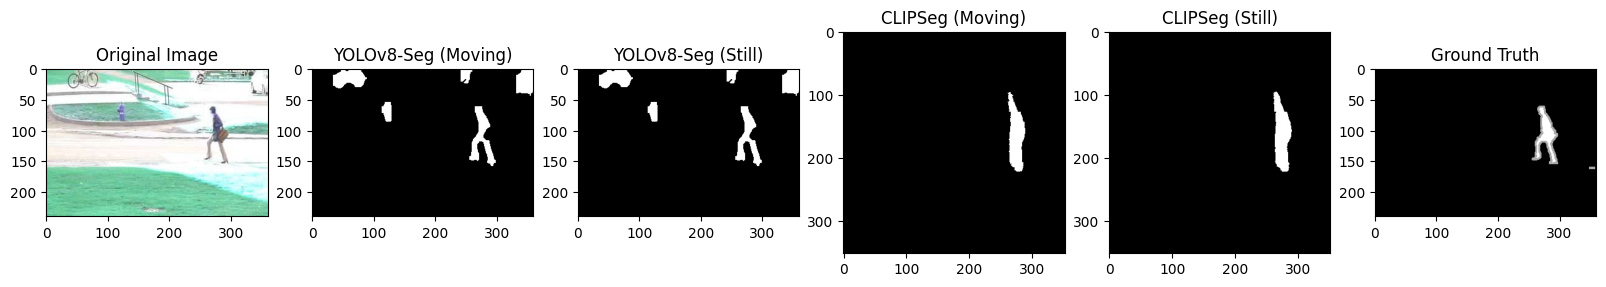

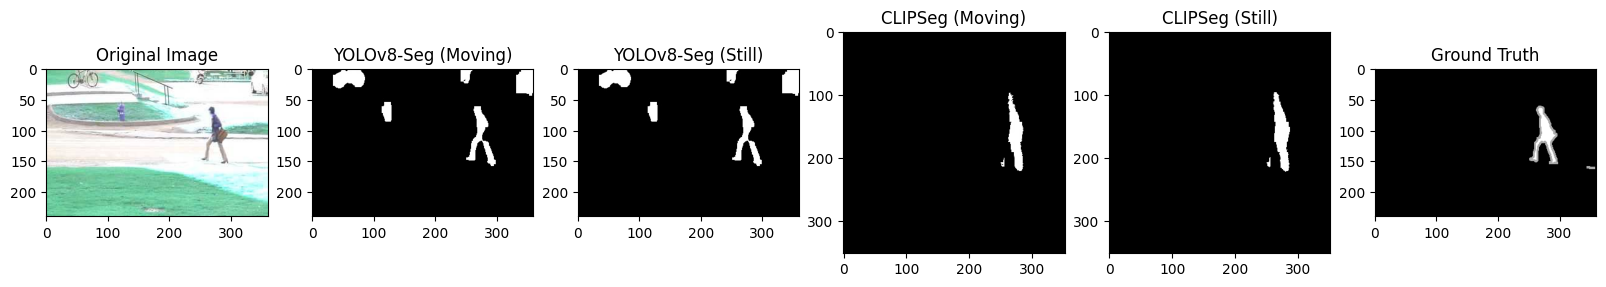

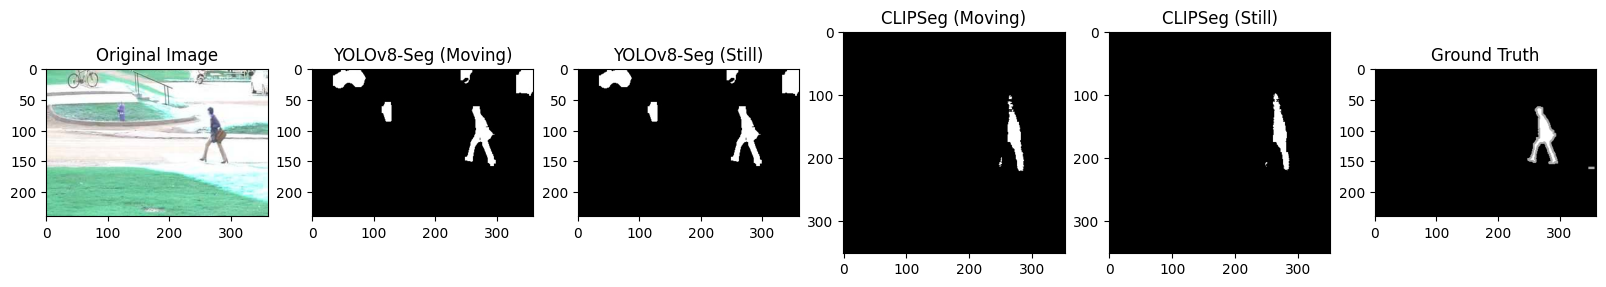

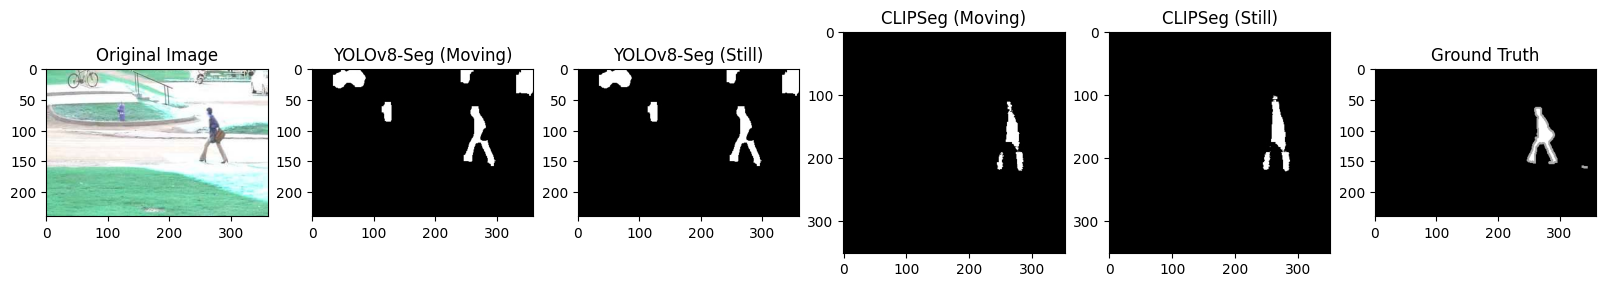

In [17]:
def show_results(image_name, yolo_moving, yolo_still, clipseg_moving, clipseg_still, gt_mask):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))

    axes[0].imshow(cv2.imread(os.path.join(INPUT_FOLDER, image_name)), cmap="gray")
    axes[0].set_title("Original Image")

    axes[1].imshow(yolo_moving, cmap="gray")
    axes[1].set_title("YOLOv8-Seg (Moving)")

    axes[2].imshow(yolo_still, cmap="gray")
    axes[2].set_title("YOLOv8-Seg (Still)")

    axes[3].imshow(clipseg_moving, cmap="gray")
    axes[3].set_title("CLIPSeg (Moving)")

    axes[4].imshow(clipseg_still, cmap="gray")
    axes[4].set_title("CLIPSeg (Still)")

    axes[5].imshow(gt_mask, cmap="gray")
    axes[5].set_title("Ground Truth")

    plt.show()

# Select a few images for visualization
sample_images = input_images[600:605]  # Show results for the first 5 images
for img_name in sample_images:
    yolo_moving = cv2.imread(os.path.join(RESULTS_FOLDER_MOVING, f"bin{img_name[2:]}"), 0)
    yolo_still = cv2.imread(os.path.join(RESULTS_FOLDER_STILL, f"bin{img_name[2:]}"), 0)
    clipseg_moving = cv2.imread(os.path.join(RESULTS_FOLDER_MOVING, f"clip_{img_name[2:]}"), 0)
    clipseg_still = cv2.imread(os.path.join(RESULTS_FOLDER_STILL, f"clip_{img_name[2:]}"), 0)
    gt_mask = cv2.imread(os.path.join(GROUNDTRUTH_FOLDER, f"gt{img_name[2:].replace('.jpg', '.png')}"), 0)

    show_results(img_name, yolo_moving, yolo_still, clipseg_moving, clipseg_still, gt_mask)


In [18]:
# Initialize metric lists
iou_scores_yolo_moving, precision_yolo_moving, recall_yolo_moving, f1_scores_yolo_moving = [], [], [], []
iou_scores_yolo_still, precision_yolo_still, recall_yolo_still, f1_scores_yolo_still = [], [], [], []
iou_scores_clipseg_moving, precision_clipseg_moving, recall_clipseg_moving, f1_scores_clipseg_moving = [], [], [], []
iou_scores_clipseg_still, precision_clipseg_still, recall_clipseg_still, f1_scores_clipseg_still = [], [], [], []


In [19]:
for image_name in input_images:
    yolo_moving_path = os.path.join(RESULTS_FOLDER_MOVING, f"bin{image_name[2:]}")
    yolo_still_path = os.path.join(RESULTS_FOLDER_STILL, f"bin{image_name[2:]}")
    clipseg_moving_path = os.path.join(RESULTS_FOLDER_MOVING, f"clip_{image_name[2:]}")
    clipseg_still_path = os.path.join(RESULTS_FOLDER_STILL, f"clip_{image_name[2:]}")

    if not os.path.exists(yolo_moving_path) or not os.path.exists(yolo_still_path):
        print(f"Skipping {image_name} (Missing YOLO results)")
        continue
    if not os.path.exists(clipseg_moving_path) or not os.path.exists(clipseg_still_path):
        print(f"Skipping {image_name} (Missing CLIPSeg results)")
        continue

    # Load predicted masks
    yolo_pred_moving = cv2.imread(yolo_moving_path, 0)
    yolo_pred_still = cv2.imread(yolo_still_path, 0)
    clipseg_pred_moving = cv2.imread(clipseg_moving_path, 0)
    clipseg_pred_still = cv2.imread(clipseg_still_path, 0)
    
    try:
        gt_mask = cv2.imread(os.path.join(GROUNDTRUTH_FOLDER, f"gt{image_name[2:].replace('.jpg', '.png')}"), 0)
    except FileNotFoundError as e:
        print(e)
        continue

    # Compute metrics
    iou_yolo_moving, prec_yolo_moving, rec_yolo_moving, f1_yolo_moving = calculate_metrics(yolo_pred_moving, gt_mask)
    iou_yolo_still, prec_yolo_still, rec_yolo_still, f1_yolo_still = calculate_metrics(yolo_pred_still, gt_mask)
    iou_clipseg_moving, prec_clipseg_moving, rec_clipseg_moving, f1_clipseg_moving = calculate_metrics(clipseg_pred_moving, gt_mask)
    iou_clipseg_still, prec_clipseg_still, rec_clipseg_still, f1_clipseg_still = calculate_metrics(clipseg_pred_still, gt_mask)

    # Store results
    iou_scores_yolo_moving.append(iou_yolo_moving)
    precision_yolo_moving.append(prec_yolo_moving)
    recall_yolo_moving.append(rec_yolo_moving)
    f1_scores_yolo_moving.append(f1_yolo_moving)

    iou_scores_yolo_still.append(iou_yolo_still)
    precision_yolo_still.append(prec_yolo_still)
    recall_yolo_still.append(rec_yolo_still)
    f1_scores_yolo_still.append(f1_yolo_still)

    iou_scores_clipseg_moving.append(iou_clipseg_moving)
    precision_clipseg_moving.append(prec_clipseg_moving)
    recall_clipseg_moving.append(rec_clipseg_moving)
    f1_scores_clipseg_moving.append(f1_clipseg_moving)

    iou_scores_clipseg_still.append(iou_clipseg_still)
    precision_clipseg_still.append(prec_clipseg_still)
    recall_clipseg_still.append(rec_clipseg_still)
    f1_scores_clipseg_still.append(f1_clipseg_still)


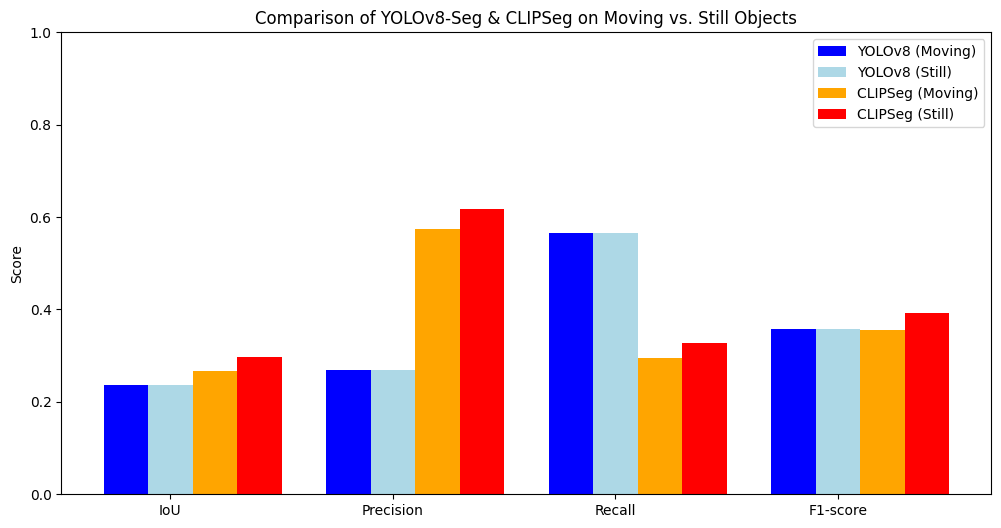

In [20]:
# Compute average scores
metrics = ["IoU", "Precision", "Recall", "F1-score"]
yolo_means_moving = [np.mean(iou_scores_yolo_moving), np.mean(precision_yolo_moving), np.mean(recall_yolo_moving), np.mean(f1_scores_yolo_moving)]
yolo_means_still = [np.mean(iou_scores_yolo_still), np.mean(precision_yolo_still), np.mean(recall_yolo_still), np.mean(f1_scores_yolo_still)]
clipseg_means_moving = [np.mean(iou_scores_clipseg_moving), np.mean(precision_clipseg_moving), np.mean(recall_clipseg_moving), np.mean(f1_scores_clipseg_moving)]
clipseg_means_still = [np.mean(iou_scores_clipseg_still), np.mean(precision_clipseg_still), np.mean(recall_clipseg_still), np.mean(f1_scores_clipseg_still)]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - width, yolo_means_moving, width, label="YOLOv8 (Moving)", color="blue")
plt.bar(x, yolo_means_still, width, label="YOLOv8 (Still)", color="lightblue")
plt.bar(x + width, clipseg_means_moving, width, label="CLIPSeg (Moving)", color="orange")
plt.bar(x + 2 * width, clipseg_means_still, width, label="CLIPSeg (Still)", color="red")

plt.xticks(ticks=x, labels=metrics)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Comparison of YOLOv8-Seg & CLIPSeg on Moving vs. Still Objects")
plt.legend()
plt.show()


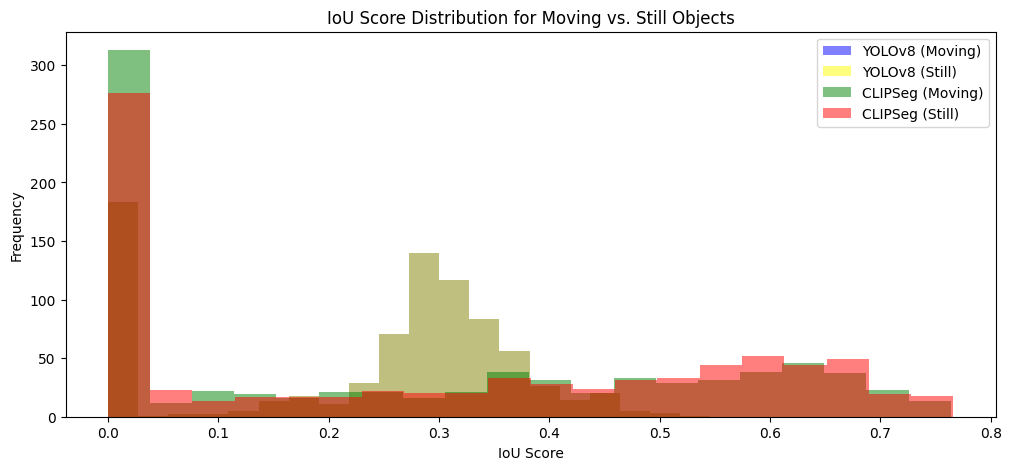

In [23]:
plt.figure(figsize=(12, 5))

plt.hist(iou_scores_yolo_moving, bins=20, alpha=0.5, label="YOLOv8 (Moving)", color="blue")
plt.hist(iou_scores_yolo_still, bins=20, alpha=0.5, label="YOLOv8 (Still)", color="yellow")
plt.hist(iou_scores_clipseg_moving, bins=20, alpha=0.5, label="CLIPSeg (Moving)", color="green")
plt.hist(iou_scores_clipseg_still, bins=20, alpha=0.5, label="CLIPSeg (Still)", color="red")

plt.xlabel("IoU Score")
plt.ylabel("Frequency")
plt.title("IoU Score Distribution for Moving vs. Still Objects")
plt.legend()
plt.show()
